# Data Preprocessing
As the second step, we will preprocess the data to prepare it for modeling.

In [798]:
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

## Loading the Data
As seen in the previous notebook, we will load the data from a CSV file. We will also specify the data types for some columns to avoid warnings.

In [799]:
df = pd.read_csv(
    'data/LoanData.csv',
    dtype={

        'CreditScoreEsEquifaxRisk': 'category',
        'CreditScoreFiAsiakasTietoRiskGrade': 'category',
        'ActiveLateLastPaymentCategory': 'category',
        'LoanCancelled': 'boolean',
        'ContractEndDate': 'string',
        'DefaultDate': 'string',
    },
)
df['ContractEndDate'] = pd.to_datetime(df['ContractEndDate'], errors='coerce')
df['DefaultDate'] = pd.to_datetime(df['DefaultDate'],     errors='coerce')

df.head()

,LoanId,LoanNumber,ListedOnUTC,BiddingStartedOn,BidsPortfolioManager,BidsApi,BidsManual,NewCreditCustomer,LoanApplicationStartedDate,LoanDate,...,GracePeriodEnd,NextPaymentDate,NextPaymentNr,NrOfScheduledPayments,ReScheduledOn,PrincipalDebtServicingCost,InterestAndPenaltyDebtServicingCost,ActiveLateLastPaymentCategory,LoanCancelled,PreviousEarlyRepaymentsBeforeLoan
0,D8EBF360-104C-420F-BEC9-000924E6EFC7,3015853,2022-09-09 12:27:01,2022-09-09 15:27:01,11.0,0.0,88.0,False,2022-09-09 15:15:03,2022-09-09,...,NaN,2024-05-27,6.0,23.0,2023-11-30,NaN,NaN,NaN,<NA>,NaN
1,C1A98DDA-5E20-429C-BBFF-0009A05354E0,3743447,2023-05-19 11:04:33,2023-05-19 14:04:33,0.0,0.0,0.0,False,2023-05-19 14:03:54,2023-05-19,...,NaN,2024-05-27,11.0,120.0,2023-07-20,NaN,NaN,91-120,<NA>,NaN
2,9B0B252E-45B9-4172-8E2D-0014A8F18117,4335414,2024-02-03 14:43:32,2024-02-03 16:43:32,0.0,0.0,0.0,False,2024-02-03 16:41:51,2024-02-03,...,NaN,2024-07-08,2.0,12.0,2024-05-12,NaN,NaN,NaN,<NA>,NaN
3,66AE108B-532B-4BB3-BAB7-0019A46412C1,483449,2016-03-23 16:07:19,2016-03-23 16:07:19,970.0,1150.0,5.0,False,2016-03-17 12:39:22,2016-03-23,...,2020-01-27,NaN,NaN,NaN,NaN,0.0,82.76,180+,<NA>,0.0
4,C7EA512A-465D-4043-A9F2-001B14C3C14E,4043783,2023-09-26 12:14:12,2023-09-26 15:14:12,0.0,0.0,0.0,False,2023-09-26 15:13:07,2023-09-26,...,NaN,2024-06-04,9.0,108.0,NaN,NaN,NaN,16-30,<NA>,NaN


## Creating target variable
We create a categorical "defaulted" column, we base this on whether the loan was:

1. Repaid: The borrower completed all scheduled payments.
2. Defaulted: The borrower missed sufficient payments and entered default.
3. Cancelled: The loan was cancelled before disbursement or early in its lifecycle.

We can get this information from the `DefaultDate`, `LoanCancelled`, and `ContractEndDate` columns.

To simplify, we will only consider the 'Defaulted' column such that it shows whether the loan defaulted (1) or not (0).

In [800]:
df['Defaulted'] = np.where(df['DefaultDate'].notnull(), 1, 0)
df['Defaulted'].value_counts(dropna=False)

Defaulted
0    275933
1    124237
Name: count, dtype: int64

## Dropping Unnecessary Columns
With the target variable created, we can drop some columns that are not needed for modeling. Through collecting expert opinions through surveys, we have identified attributes that may be more relevant for modeling and those that are not.

### Making a manual selection of features

In [801]:
# TODO: Consider which features were ranked highly in the survey AND also do not leak information

# These features describe the applicant's profile at the time of application.
borrower_details = [
    'Age',
    'Gender',
    'Education',
    'HomeOwnershipType',
    'EmploymentDurationCurrentEmployer',
    'VerificationType',
]

# These features describe the borrower's past performance on the platform.
borrower_history_details = [
    'NewCreditCustomer',
    'NoOfPreviousLoansBeforeLoan',
    'AmountOfPreviousLoansBeforeLoan',
    'PreviousRepaymentsBeforeLoan',
    'PreviousEarlyRepaymentsBeforeLoan',
    'PreviousEarlyRepaymentsCountBeforeLoan',
]

# These features describe the loan itself and the applicant's financial situation.
loan_and_financial_details = [
    'Amount',
    'AppliedAmount',
    'Interest',
    'LoanDuration',
    'MonthlyPayment',
    'IncomeTotal',
    'LiabilitiesTotal',
    'ExistingLiabilities',
]


# Bondora's own risk metrics (could be used as extra features, or leave out to make it non-dependent on Bondora's risk assessment).
bondora_assessment_details = [
    'Rating',
    'ExpectedLoss',
    'LossGivenDefault',
    'ProbabilityOfDefault',
]

# Combine all the features into a single list
selected_features = (
    borrower_details +
    borrower_history_details +
    loan_and_financial_details
    # + bondora_assessment_details
)

# Filter the DataFrame to keep only the selected features and the target variable (+ 'LoanDate' for splitting later)
df = df[selected_features + ['Defaulted'] + ['LoanDate']].copy()

#### Dropping Obsolete Features
Bondora mentions in their API that some features are obsolete and will not be updated anymore. We will drop these features from the dataset, in case some are still present in the df. We will use the `data/public_dataset_item.csv` file to identify these obsolete features (obtained using the `export_bondora_specification.js` script in the `scripts` folder).

In [802]:
features_metadata_df = pd.read_csv('data/public_dataset_item.csv')
is_obsolete = features_metadata_df['additionalInfo'].str.startswith('Obsolete', na=False)
obsolete_features = features_metadata_df.loc[is_obsolete, 'name'].tolist()


dropped_features = [feat for feat in obsolete_features if feat in df.columns]

if dropped_features:
    df.drop(columns=dropped_features, inplace=True)

if dropped_features:
    print("Dropped obsolete features:", dropped_features)
else:
    print("No obsolete features to drop based on the provided metadata.")

Dropped obsolete features: ['HomeOwnershipType', 'IncomeTotal']


## Cleaning Types
There are still some columns that are of type `object` that should be converted to more appropriate types.

In [803]:
# Check which columns are still present as object types
df.select_dtypes(include=['object']).columns.tolist()

['EmploymentDurationCurrentEmployer', 'LoanDate']

In [804]:
# EmploymentDurationCurrentEmployer
emp_order = [
    'TrialPeriod',
    'UpTo1Year',
    'UpTo2Years',
    'UpTo3Years',
    'UpTo4Years',
    'UpTo5Years',
    'MoreThan5Years',
    'Retiree',
    'Other'
]
df['EmploymentDurationCurrentEmployer'] = df['EmploymentDurationCurrentEmployer'].astype(
    CategoricalDtype(categories=emp_order, ordered=False)
)

In [805]:
# LoanDate
df['LoanDate'] = pd.to_datetime(df['LoanDate'], format='ISO8601')

In [806]:
# Sanity check: Check for remaining object columns
df.select_dtypes(include=['object']).columns.tolist()

[]

## Handling Missing Values
As seen during data exploration, there are some missing values in the dataset. However, dropping this data, or simply imputing the missing values is not a good idea, as the missing data holds semantic meaning. Thus, we will examine all columns with missing values and decide how to handle them.

In [807]:
# Summarize missing values per column
def summarize_missing_values(df):
    """Summarizes missing values in the DataFrame."""
    missing_summary = (
        df.isnull()
          .sum()
          .reset_index()
          .rename(columns={'index': 'Feature', 0: 'MissingCount'})
    )
    missing_summary['MissingPercent'] = 100 * missing_summary['MissingCount'] / len(df)
    return missing_summary[missing_summary['MissingCount'] > 0].sort_values(by='MissingPercent', ascending=False).reset_index(drop=True)

summarize_missing_values(df)

,Feature,MissingCount,MissingPercent
0,PreviousEarlyRepaymentsBeforeLoan,337407,84.315916
1,PreviousRepaymentsBeforeLoan,152193,38.032086
2,EmploymentDurationCurrentEmployer,13894,3.472024
3,MonthlyPayment,6690,1.671789
4,PreviousEarlyRepaymentsCountBeforeLoan,83,0.020741
5,NoOfPreviousLoansBeforeLoan,82,0.020491
6,AmountOfPreviousLoansBeforeLoan,82,0.020491
7,Education,50,0.012495
8,VerificationType,50,0.012495
9,Gender,45,0.011245


In [808]:
# PreviousEarlyRepaymentsBeforeLoan

# print(df['PreviousEarlyRepaymentsBeforeLoan'].value_counts(dropna=False))

# We will assume that NaN means that the borrower had no previous early repayments before the loan, therefore, we will fill NaN with 0.
df['PreviousEarlyRepaymentsBeforeLoan'] = df['PreviousEarlyRepaymentsBeforeLoan'].fillna(0).astype(int)

In [809]:
# PreviousRepaymentsBeforeLoan

# print(df['PreviousRepaymentsBeforeLoan'].value_counts(dropna=False))
df['PreviousRepaymentsBeforeLoan'] = df['PreviousRepaymentsBeforeLoan'].fillna(0).astype(int)

In [810]:
# EmploymentDurationCurrentEmployer

print(df['EmploymentDurationCurrentEmployer'].value_counts(dropna=False))

# We will assume that NaN means that the employment duration is unknown, likely because the borrower did not provide this information. Therefore, we will fill NaN with 'Unknown'.
col_name = 'EmploymentDurationCurrentEmployer'
df[col_name] = df[col_name].cat.add_categories(['Unknown'])
df[col_name] = df[col_name].fillna('Unknown')
all_categories = df[col_name].unique().tolist()
df[col_name] = df[col_name].astype(pd.CategoricalDtype(categories=all_categories, ordered=False))


EmploymentDurationCurrentEmployer
MoreThan5Years    144562
UpTo5Years        106748
UpTo1Year          69949
Retiree            24712
Other              23912
NaN                13894
UpTo2Years          6504
UpTo3Years          5445
UpTo4Years          3691
TrialPeriod          753
Name: count, dtype: int64


In [811]:
# MonthlyPayment
print(df['MonthlyPayment'].value_counts(dropna=False))

# Missing for unknown reason, we will impute with the median value (not affected by outliers).
median_payment = df['MonthlyPayment'].median()
#NOTE: This is being done before the data is split, so the median is calculated on the entire dataset. Not preferable due to potential data leakage, but we will assume that the median is a good estimate for the missing values.
df['MonthlyPayment'] = df['MonthlyPayment'].fillna(median_payment)

MonthlyPayment
108.17    12239
108.27    12008
NaN        6690
103.75     6683
13.51      4707
          ...  
457.89        1
280.60        1
116.56        1
266.22        1
519.00        1
Name: count, Length: 30794, dtype: int64


In [812]:
# PreviousEarlyRepaymentsCountBeforeLoan

# print(df['PreviousEarlyRepaymentsCountBeforeLoan'].value_counts(dropna=False))
df['PreviousEarlyRepaymentsCountBeforeLoan'] = df['PreviousEarlyRepaymentsCountBeforeLoan'].fillna(0).astype(int)

In [813]:
# NoOfPreviousLoansBeforeLoan

# print(df['NoOfPreviousLoansBeforeLoan'].value_counts(dropna=False))
df['NoOfPreviousLoansBeforeLoan'] = df['NoOfPreviousLoansBeforeLoan'].fillna(0).astype(int)

In [814]:
# AmountOfPreviousLoansBeforeLoan

# print(df['AmountOfPreviousLoansBeforeLoan'].value_counts(dropna=False))
df['AmountOfPreviousLoansBeforeLoan'] = df['AmountOfPreviousLoansBeforeLoan'].fillna(0).astype(float)

In [815]:
# Education

# print(df['Education'].value_counts(dropna=False))

# We will leave out the few rows with NaN values (50 rows, where VerificationType and Gender also were NaN).
df = df.dropna(subset=['Education'])

In [816]:
# Sanity check.
summarize_missing_values(df)

,Feature,MissingCount,MissingPercent


We have handled all missing values in a way that preserves the meaning of the data.

## One-Hot Encoding
With all data types cleaned and missing values handled, we can now proceed to one-hot encode the categorical features.

In [817]:
# Check the DataFrame info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400120 entries, 0 to 400169
Data columns (total 20 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   Age                                     400120 non-null  int64         
 1   Gender                                  400120 non-null  float64       
 2   Education                               400120 non-null  float64       
 3   EmploymentDurationCurrentEmployer       400120 non-null  category      
 4   VerificationType                        400120 non-null  float64       
 5   NewCreditCustomer                       400120 non-null  bool          
 6   NoOfPreviousLoansBeforeLoan             400120 non-null  int64         
 7   AmountOfPreviousLoansBeforeLoan         400120 non-null  float64       
 8   PreviousRepaymentsBeforeLoan            400120 non-null  int64         
 9   PreviousEarlyRepaymentsBeforeLoan       40

There are a few features that are worth looking at more closely:
- `Gender`: float64, we got 3 unique values, assuming that one is male, the other is female, and the third is other, or prefers not to disclose. These are codes for different groups, so we will one-hot encode this column.
- `Education`: float64, similarly to  `Gender`,these are codes for different education levels, so we will one-hot encode this column.
- `EmploymentDurationCurrentEmployer` category, so the dtype already shows that it is categorical, but we will one-hot encode it to create binary features for each category.
- `VerificationType`: float64, these are codes for different verification types, so we will one-hot encode this column.

All the other columns do not need one-hot encoding.

In [818]:
# Define the categorical features to encode
categorical_features_to_encode = [
    'Gender',
    'Education',
    'EmploymentDurationCurrentEmployer',
    'VerificationType',
]

# One-hot encode the categorical features
df = pd.get_dummies(df, columns=categorical_features_to_encode, drop_first=False)
# Note how drop_first=False is used to keep all categories, this is for now done due to explainability purposes, as we want to see all categories in the final dataset. In practice, you might want to set this to True to avoid multicollinearity. (i.e. this will help with SHAP plots later on) (+ XGBoost / LightGBM should be robust to multicollinearity).

# Check the DataFrame info again to see the changes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400120 entries, 0 to 400169
Data columns (total 41 columns):
 #   Column                                            Non-Null Count   Dtype         
---  ------                                            --------------   -----         
 0   Age                                               400120 non-null  int64         
 1   NewCreditCustomer                                 400120 non-null  bool          
 2   NoOfPreviousLoansBeforeLoan                       400120 non-null  int64         
 3   AmountOfPreviousLoansBeforeLoan                   400120 non-null  float64       
 4   PreviousRepaymentsBeforeLoan                      400120 non-null  int64         
 5   PreviousEarlyRepaymentsBeforeLoan                 400120 non-null  int64         
 6   PreviousEarlyRepaymentsCountBeforeLoan            400120 non-null  int64         
 7   Amount                                            400120 non-null  float64       
 8   AppliedAmount      

## Scaling Data
With the data one-hot encoded, we can continue with scaling the numerical features. This is necessary for some machine learning algorithms, such as logistic regression, SVM, and KNN, which are sensitive to the scale of the features.

Before we scale the data, we will split it into training and test sets to avoid data leakage. We will use the `LoanDate` column to split the data chronologically, ensuring that the training set contains only data from before the test set. After the split, we can drop the column, and continue with scaling the numerical features.

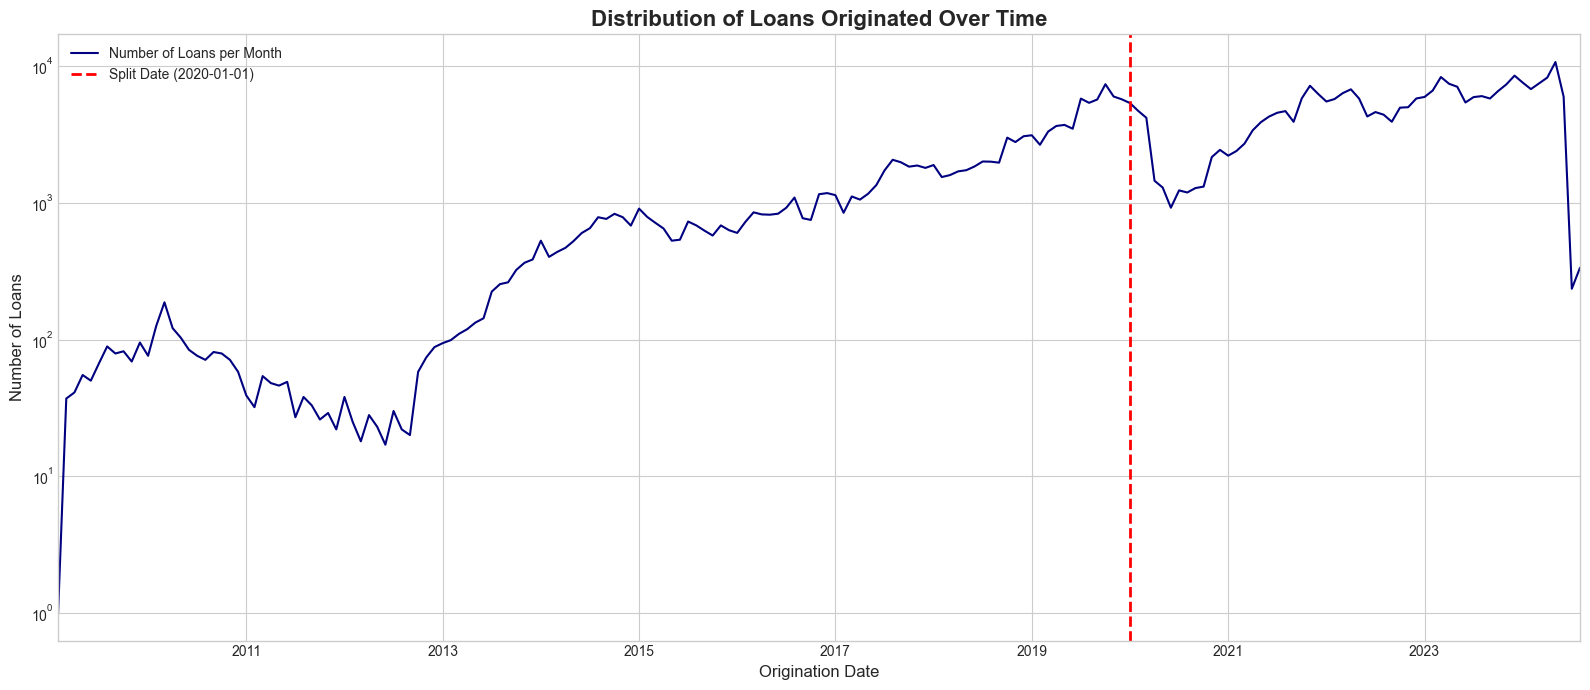

In [819]:
# Visualizing the LoanDate column to understand the distribution of the data over time
loans_by_month = df['LoanDate'].groupby(df['LoanDate'].dt.to_period('M')).size()

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 7))

loans_by_month.plot(kind='line', ax=ax, color='navy', label='Number of Loans per Month')

split_date = pd.to_datetime('2020-01-01') # Note that covid started around this time!
ax.axvline(
    x=split_date,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'Split Date ({split_date.date()})'
)

ax.set_title('Distribution of Loans Originated Over Time', fontsize=16, fontweight='bold')
ax.set_xlabel('Origination Date', fontsize=12)
ax.set_ylabel('Number of Loans', fontsize=12)
ax.legend()
ax.set_yscale('log')
plt.tight_layout()
plt.show()

In [820]:
# Split using a specific date into training/validation and test sets
split_date = pd.to_datetime('2020-01-01')
train_val_df = df[df['LoanDate'] < split_date]
test_df = df[df['LoanDate'] >= split_date]

# Drop the LoanDate column from both DataFrames
train_val_df = train_val_df.drop(columns=['LoanDate'])
test_df = test_df.drop(columns=['LoanDate'])

# Check the shapes of the resulting DataFrames
print(f"Training/Validation set shape: {train_val_df.shape}")
print(f"Test set shape: {test_df.shape}")

Training/Validation set shape: (130082, 40)
Test set shape: (270038, 40)


In [821]:
# Split training/validation set into training and validation sets
X = train_val_df.drop(columns=['Defaulted'])
y = train_val_df['Defaulted']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=0, shuffle=False
)
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {test_df.shape}")

Training set shape: (104065, 39)
Validation set shape: (26017, 39)
Test set shape: (270038, 40)


In [822]:
# Start scaling the numerical features
numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])

StandardScaler()

In [823]:
# Transform the training, validation, and test sets
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()

# Dropping the target variable from the test set
X_test = test_df.drop(columns=['Defaulted'])
y_test = test_df['Defaulted']
X_test_scaled = X_test.copy()

# Apply transformation
X_train_scaled[numerical_features] = scaler.transform(X_train[numerical_features])
X_val_scaled[numerical_features] = scaler.transform(X_val[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

# Verification: We expect 0 for x_train, and around, but not exactly, 0 for x_val and x_test
print(f"\nMean of 'Age' in scaled training data:   {X_train_scaled['Age'].mean():.4f}")
print(f"Mean of 'Age' in scaled validation data: {X_val_scaled['Age'].mean():.4f}")
print(f"Mean of 'Age' in scaled test data:       {X_test_scaled['Age'].mean():.4f}")


Mean of 'Age' in scaled training data:   0.0000
Mean of 'Age' in scaled validation data: 0.0627
Mean of 'Age' in scaled test data:       -0.0429


In [824]:
# Exporting the preprocessed data

# Check if a 'ml' directory exists, if not, create it
if not os.path.exists('ml'):
    os.makedirs('ml')

X_train_scaled.to_csv('ml/X_train_scaled.csv', index=False)
X_val_scaled.to_csv('ml/X_val_scaled.csv', index=False)
X_test_scaled.to_csv('ml/X_test_scaled.csv', index=False)
y_train.to_csv('ml/y_train.csv', index=False)
y_val.to_csv('ml/y_val.csv', index=False)
y_test.to_csv('ml/y_test.csv', index=False)
print("Preprocessed data saved to 'ml' directory.")

Preprocessed data saved to 'ml' directory.
